In [147]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Error metrics
from sklearn.metrics import mean_squared_error

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [63]:
pip install keras

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

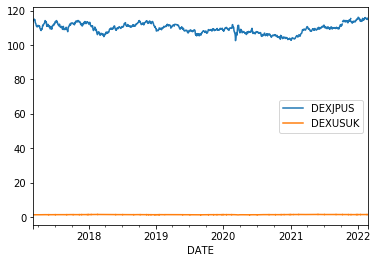

In [10]:
ccy_data.plot();

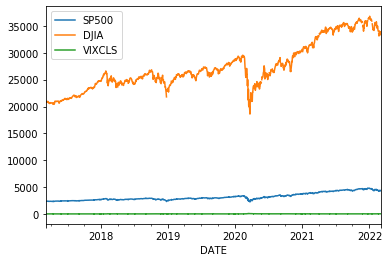

In [11]:
idx_data.plot();

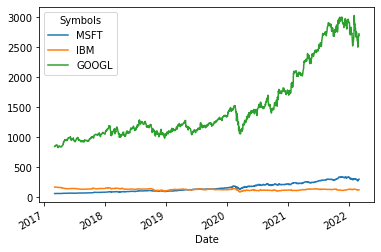

In [12]:
stk_data['Open'].plot();

In [13]:
return_period = 5

In [14]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [15]:
Y.name = 'MSFT_pred'

In [16]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

#### Exploratory data analysis

##### 3.1 Descriptive analysis

In [17]:
pd.set_option('precision', 3)
dataset.describe()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,2.250e+02,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,1.818e-04,0.003,2.756e-05,-4.806e-04,0.001,0.001,0.009,0.006,0.018,0.038,0.081,0.006
std,3.771e-02,0.037,8.897e-03,1.220e-02,0.026,0.028,0.177,0.033,0.050,0.065,0.074,0.034
min,-1.683e-01,-0.159,-3.293e-02,-5.492e-02,-0.162,-0.190,-0.559,-0.145,-0.165,-0.288,-0.159,-0.153
25%,-1.756e-02,-0.014,-5.348e-03,-6.905e-03,-0.008,-0.008,-0.087,-0.013,-0.008,0.004,0.043,-0.013
50%,2.102e-03,0.007,4.806e-04,-1.442e-03,0.004,0.004,-0.002,0.008,0.017,0.041,0.085,0.007
75%,1.734e-02,0.023,5.467e-03,6.167e-03,0.015,0.014,0.092,0.024,0.052,0.076,0.130,0.026
max,1.304e-01,0.134,3.800e-02,5.121e-02,0.098,0.121,0.910,0.100,0.186,0.285,0.283,0.100


In [18]:
dataset.head()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2017-05-31,0.004,0.017,-0.012,-0.002,3.077e-03,-1.794e-04,0.038,0.017,0.017,0.072,0.089,0.036
2017-06-08,-0.004,0.016,-0.010,0.003,1.534e-03,1.812e-03,0.027,0.026,0.064,0.065,0.116,-0.029
2017-06-15,0.014,-0.045,0.005,-0.013,-5.466e-04,8.339e-03,0.070,-0.029,0.016,0.018,0.091,0.005
2017-06-22,0.001,0.017,0.006,-0.009,8.383e-04,1.749e-03,-0.039,0.005,0.002,0.019,0.079,-0.026
2017-06-29,-0.002,-0.041,0.009,0.025,-6.098e-03,-5.166e-03,0.088,-0.026,-0.049,0.015,0.047,0.014


In [19]:
dataset.dtypes

IBM          float64
GOOGL        float64
DEXJPUS      float64
DEXUSUK      float64
SP500        float64
DJIA         float64
VIXCLS       float64
MSFT_DT      float64
MSFT_3DT     float64
MSFT_6DT     float64
MSFT_12DT    float64
MSFT_pred    float64
dtype: object

##### 3.2 Data visualization

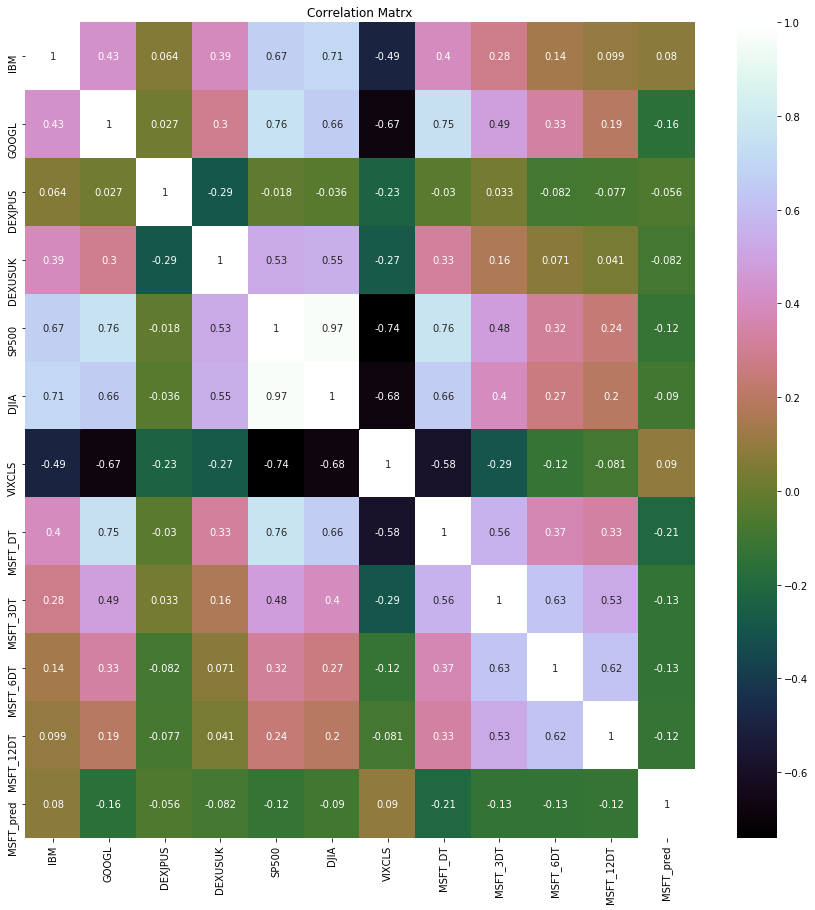

In [20]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrx')
sns.heatmap(correlation, vmax=1, annot=True, cmap='cubehelix')

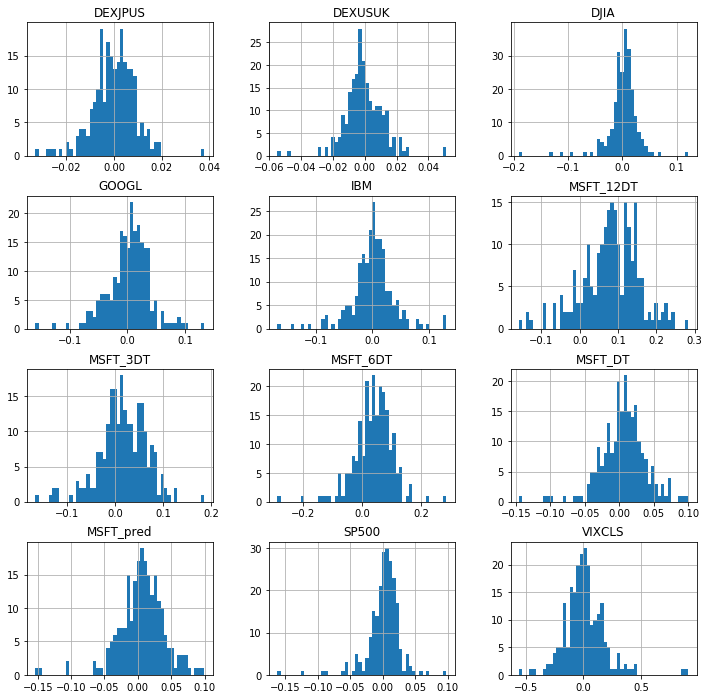

In [21]:
dataset.hist(bins=50, sharex=False, sharey=False,figsize=(12,12));

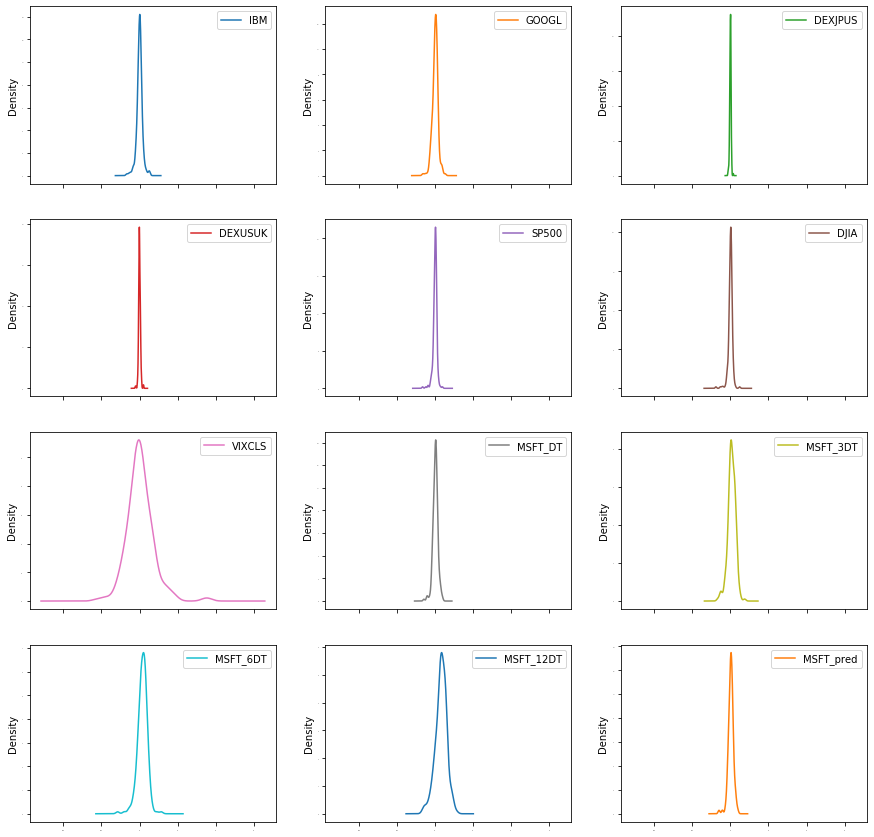

In [22]:
dataset.plot(kind='density', subplots=True, layout=(4,3), legend=True, fontsize=1, sharex=True, figsize=(15,15));

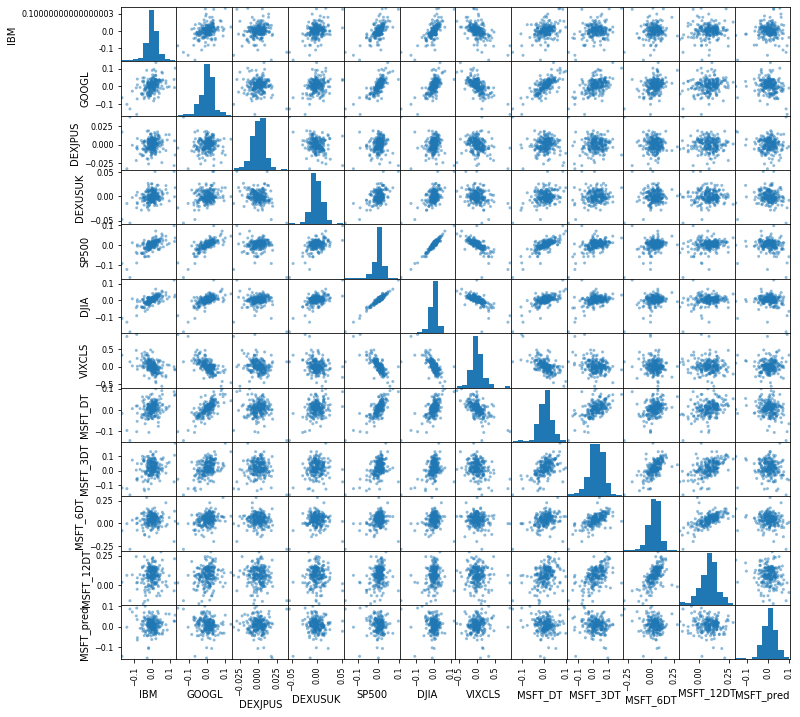

In [23]:
scatter_matrix(dataset, figsize=(12,12));

##### 3.3 Time Series Analysis

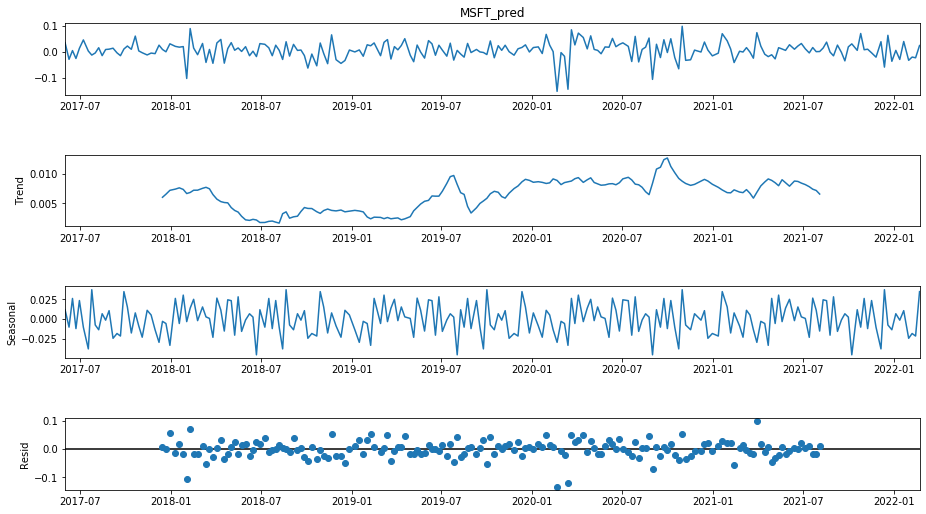

In [24]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 4. Data Preparation
###### 4.2. Feature Selection

In [25]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(10, 'Score').set_index('Specs')

,Score
Specs,
MSFT_DT,10.084
GOOGL,5.840
MSFT_6DT,4.134
MSFT_3DT,3.786
MSFT_12DT,3.500
SP500,3.372
VIXCLS,1.838
DJIA,1.809
DEXUSUK,1.497


#### 5. Evalute Algorithms and models

##### 5.1 Train test split and evaluation metrics

In [26]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

##### 5.2 Test Options and evaluation metrics

In [27]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

##### 5.3 Compare Models and Algorithms

###### 5.3.1 Machine learning models from scikit-learn

In [28]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('RID', Ridge()))

models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))


# Neural Network algorithms
models.append(('LR', MLPRegressor()))

# Ensamble models
#  Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

#  Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [107]:
names = []
kfold_results = []
train_results = []

= []

for name, model in models:
    names.append(name)
    
    # K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    cv_result = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_result)
    
    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    print("%s: %f (%f) %f %f" % (name, cv_result.mean(), cv_result.std(), train_result, test_result))

LR: 0.001327 (0.001092) 0.001041 0.001260
LASSO: 0.001260 (0.001007) 0.001257 0.000805
EN: 0.001260 (0.001007) 0.001257 0.000805
RID: 0.001267 (0.001074) 0.001189 0.000818
KNN: 0.001476 (0.001180) 0.000968 0.001097
CART: 0.002824 (0.001616) 0.000000 0.001976
SVR: 0.002553 (0.000819) 0.002492 0.002230
LR: 0.002175 (0.001709) 0.003230 0.002383
ABR: 0.001390 (0.001023) 0.000588 0.000903
GBR: 0.001684 (0.001351) 0.000083 0.001021
RFR: 0.001507 (0.001191) 0.000207 0.000869
ETR: 0.001559 (0.001352) 0.000000 0.000923


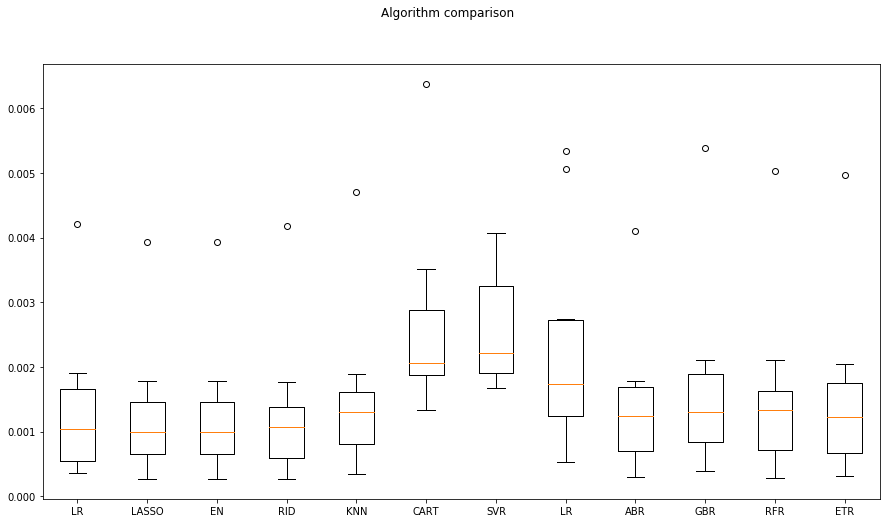

In [101]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

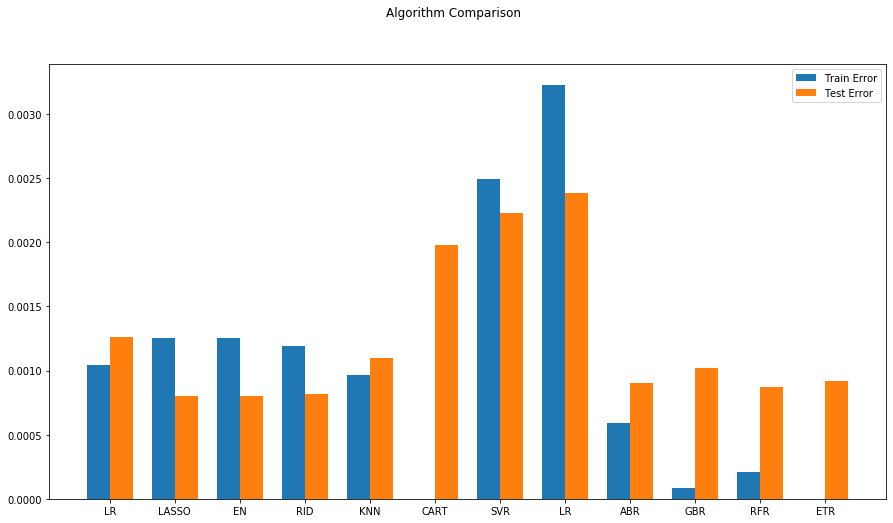

In [108]:
def plot_errors():
    fig = pyplot.figure()
    ind = np.arange(len(names))
    width = 0.35

    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
    pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
    fig.set_size_inches(15,8)
    pyplot.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(names)
    pyplot.show()

plot_errors()

### Time series model - ARIMA model

In [32]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [33]:
error_Train_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len-1, end = to_len-1, exog= X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [34]:
error_Test_ARIMA

0.001226479748402756

### LSTM Model

In [56]:
seq_len = 2 # Length of the seq for the LSTM

Y_train_LSTM = np.array(Y_train)[seq_len-1:]
Y_test_LSTM = np.array(Y_test)

X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [79]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [74]:
LSTMModel_fit

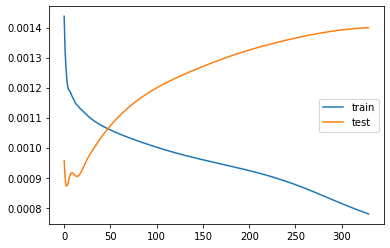

In [73]:
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [92]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [78]:
error_Training_LSTM

0.0007764667975636394

In [109]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Train_ARIMA)
train_results.append(error_Train_LSTM)

names.append("ARIMA")
names.append("LSTM")

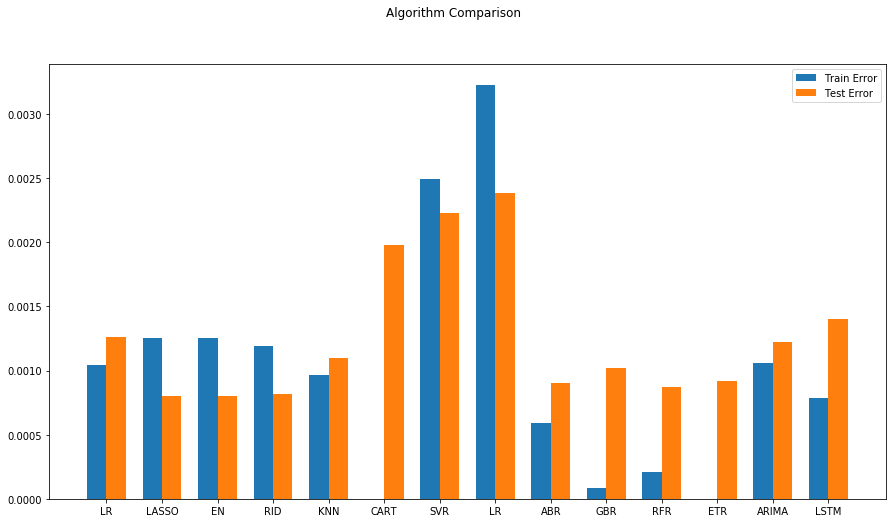

In [110]:
plot_errors()

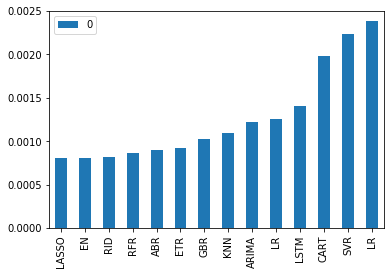

In [121]:
pd.DataFrame(test_results, index=names).sort_values(0).plot(kind='bar');

### Model tuning and Grid search

In [150]:
def evaluate_arima_model(arima_order, enforce_stationarity):
    """arima_order: (p,q,d) tuple"""

    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order,enforce_stationarity=enforce_stationarity)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

evaluate_arima_model([1,0,2], False)

0.001063226691232899

In [154]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values, enforce_stationarity): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for es in enforce_stationarity:
                    order = (p,d,q)               
                    mse = evaluate_arima_model(order, es)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, (order, es)
                        print('Found new best order', order)
                    print('ARIMA%s MSE=%.7f' % ((order, es),mse))

    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = [0]
q_values = [0, 1, 2]
enforce_stationarity = [True, False]

evaluate_models(p_values, d_values, q_values, enforce_stationarity)   

Found new best order (0, 0, 0)
ARIMA((0, 0, 0), True) MSE=0.0010720
ARIMA((0, 0, 0), False) MSE=0.0010721
Found new best order (0, 0, 1)
ARIMA((0, 0, 1), True) MSE=0.0010637
ARIMA((0, 0, 1), False) MSE=0.0010640
Found new best order (0, 0, 2)
ARIMA((0, 0, 2), True) MSE=0.0010607
ARIMA((0, 0, 2), False) MSE=0.0010616
ARIMA((1, 0, 0), True) MSE=0.0010619
ARIMA((1, 0, 0), False) MSE=0.0010618
ARIMA((1, 0, 1), True) MSE=0.0010613
ARIMA((1, 0, 1), False) MSE=0.0010607
ARIMA((1, 0, 2), True) MSE=0.0010609
ARIMA((1, 0, 2), False) MSE=0.0010632
ARIMA((2, 0, 0), True) MSE=0.0010612
ARIMA((2, 0, 0), False) MSE=0.0010615
ARIMA((2, 0, 1), True) MSE=0.0010619
ARIMA((2, 0, 1), False) MSE=0.0010685
ARIMA((2, 0, 2), True) MSE=0.0010654
ARIMA((2, 0, 2), False) MSE=0.0010638
Found new best order (3, 0, 0)
ARIMA((3, 0, 0), True) MSE=0.0010605
ARIMA((3, 0, 0), False) MSE=0.0010607
ARIMA((3, 0, 1), True) MSE=0.0010609
ARIMA((3, 0, 1), False) MSE=0.0010609
ARIMA((3, 0, 2), True) MSE=0.0010606
ARIMA((3, 0, 2

#### Finalise the model

In [165]:
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [166]:
predicted_tuned = model_fit_tuned.predict(start = tr_len-1, end = to_len-1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.0012281121104728205


In [ ]:
0.0012281121104728205